# To Do
- Wisselkoersen (valuta winst/verlies toevoegen). Of wordt hier al rekening mee gehouden gezien euro kosten worden gebruikt?
- Acc etfs. 
- Dividend
- Alter initial handling. Check first if current quantity is 0, change intial row. Else 'normal' initial row

In [31]:
import pandas as pd
import yfinance as yf
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [32]:
# Process transaction data
df = pd.read_csv('data\Transactions.csv')

In [33]:
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


| Datum      | Tijd   | Product                                     | ISIN         | Beurs   | Uitvoeringsplaats   | Aantal   | Koers   | Unnamed: 8   | Lokale waarde   | Unnamed: 10   | Waarde   | Unnamed: 12   | Wisselkoers   | Transactiekosten en/of   | Unnamed: 15   | Totaal   | Unnamed: 17   | Order ID                             |
|:-----------|:-------|:--------------------------------------------|:-------------|:--------|:--------------------|:---------|:--------|:-------------|:----------------|:--------------|:---------|:--------------|:--------------|:-------------------------|:--------------|:---------|:--------------|:-------------------------------------|
| 25-10-2024 | 10:24  | ISHARES MSCI WORLD SRI UCITS ETF            | IE00BYX2JD69 | XET     | XETA                | 46       | 11.46   | EUR          | -527.16         | EUR           | -527.16  | EUR           | nan           | -1                       | EUR           | -528.16  | EUR           | 8b995f92-ab6b-4091-988

In [34]:
# Select and rename the columns
df_adj = df[['Datum', 'ISIN', 'Beurs', 'Aantal', 'Koers', 'Waarde', 'Transactiekosten en/of']].rename(columns={
    'Datum': 'Date',
    'ISIN': 'ISIN',
    'Beurs': 'Exchange',
    'Aantal': 'Quantity',
    'Koers': 'Price',
    'Waarde': 'Cost',
    'Transactiekosten en/of': 'Transaction_costs'
})

In [35]:
df_adj['ISIN'].unique()

array(['IE00BYX2JD69', 'IE00BYVQ9F29', 'US70450Y1038', 'IE00BFNM3P36',
       'LU0629460832', 'IE00B52VJ196', 'LU0629460089', nan,
       'US18915M1071', 'US60937P1066', 'US88688T1007', 'CA86730L1094',
       'US8522341036', 'US36467W1099', 'CA09228F1036', 'US79466L3024',
       'US69608A1088', 'IE00BYVJRP78'], dtype=object)

In [36]:
# Define a mapping from ISIN to ticker symbols
isin_to_stock_ticker = {
    'IE00BYVQ9F29': 'NQSE.DE',
    'IE00BYX2JD69': '2B7K.DE',
    'US70450Y1038': 'PYPL',
    'IE00BFNM3P36': 'AYEM.DE',
    'LU0629460832': 'UIMT.AS',
    'IE00B52VJ196': 'IESE.AS',
    'LU0629460089': 'UIMP.AS',
    'US18915M1071': 'NET',
    'US60937P1066': 'MDB',
    'US88688T1007': 'TLRY',
    'CA86730L1094': 'SNDL',
    'US8522341036': 'SQ',
    'US36467W1099': 'GME',
    'CA09228F1036': 'BB.TO',
    'US79466L3024': 'CRM',
    'US69608A1088': 'PLTR',
    'IE00BYVJRP78': 'SUSM.L'
}

ticker_to_name = {
    'NQSE.DE': 'Nasdaq',
    '2B7K.DE': 'World',
    'PYPL': 'PayPal',
    'AYEM.DE': 'Emerging markets',
    'UIMT.AS': 'Pacific',
    'IESE.AS': 'Europe',
    'UIMP.AS': 'USA',
    'NET': 'Cloudflare',
    'MDB': 'MongoDB',
    'TLRY': 'Tilray Brands',
    'SNDL': 'SNDL Inc.',
    'SQ': 'Block Inc.',
    'GME': 'GameStop',
    'BB.TO': 'BlackBerry',
    'CRM': 'Salesforce Inc.',
    'PLTR': 'Palantir Technologies',
    'SUSM.L': 'Emerging markets'
}

In [37]:
# Map the ISIN values to the new Ticker column
df_adj['Stock'] = df_adj['ISIN'].map(isin_to_stock_ticker).astype(str)

# Filter out rows where ISIN cannot be mapped
df_adj = df_adj[df_adj['Stock'] != 'nan']

# Map the ISIN values to the new Product_name column
df_adj['Product'] = df_adj['Stock'].map(ticker_to_name).astype(str)

# Add the Action column based on the Quantity
df_adj['Action'] = df_adj['Quantity'].apply(lambda x: 'BUY' if x > 0 else 'SELL')

# Convert the Date column to the desired format
df_adj['Date'] = pd.to_datetime(df_adj['Date'], format='%d-%m-%Y')

# Fill NA in transaction costs
df_adj['Transaction_costs'] = df_adj['Transaction_costs'].fillna(0)

In [38]:
df_adj[df_adj['Stock']=='PYPL']

,Date,ISIN,Exchange,Quantity,Price,Cost,Transaction_costs,Stock,Product,Action
5,2024-07-17,US70450Y1038,NDQ,-3.0,61.78,169.46,-2.0,PYPL,PayPal,SELL
21,2022-04-04,US70450Y1038,NDQ,1.0,118.80,-108.11,-0.5,PYPL,PayPal,BUY
34,2021-02-24,US70450Y1038,NDQ,1.0,264.00,-217.70,-0.5,PYPL,PayPal,BUY
35,2021-02-12,US70450Y1038,NDQ,1.0,291.00,-240.62,-0.5,PYPL,PayPal,BUY


In [39]:
#df_adj.to_csv("df_adj.csv", index=False)


In [40]:
first_date = df_adj['Date'].min()
print(first_date.strftime('%Y-%m-%d'))

2020-11-27


In [41]:
class PortfolioAnalyzer:
    def __init__(self, transactions):
        """Initialize with transaction data (pandas DataFrame)."""
        self.transactions = transactions

    def get_price_at_date(self, stock, date):
        """Fetches stock price at a specific date using yfinance."""
        stock_data = yf.Ticker(stock)
        history = stock_data.history(start=date, end=(datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d'))
        return float(history['Close'].iloc[0]) if not history.empty else None

    def get_first_last_open_day(self, stock, start_date, end_date, first=True):
        """Fetches the first or last open market day within a given date range."""
        stock_data = yf.Ticker(stock)
        history = stock_data.history(start=start_date, end=end_date)
        if first:
            return history.index[0].strftime('%Y-%m-%d') if not history.empty else start_date
        else:
            return history.index[-1].strftime('%Y-%m-%d') if not history.empty else end_date
    
    def calculate_mwr(self, stock, start_date='2021-01-01', end_date=date.today().strftime('%Y-%m-%d')):
        """Calculate Money Weighted Return using individual performance tracking for each transaction."""

        # Sort transactions chronologically
        self.transactions = self.transactions.sort_values(by="Date").reset_index(drop=True)
        
        # Convert dates to datetime format
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d') + pd.Timedelta(days=1)

        # Filter transactions within the date range
        period_transactions = self.transactions[(self.transactions["Date"] >= start_date) & (self.transactions["Date"] <= end_date) & (self.transactions['Stock'] == stock)]
        previous_transactions = self.transactions[(self.transactions["Date"] < start_date) & (self.transactions['Stock'] == stock)]

        all_transactions = pd.concat([previous_transactions, period_transactions], ignore_index=True)

        # Product name
        product = ticker_to_name.get(stock) 
        
        # Average cost
        if not all_transactions.empty:
            quantity_bought = all_transactions[(all_transactions['Action'].isin(['BUY'])) & all_transactions['Quantity']>0]['Quantity'].sum()
            avg_cost = -1 * (all_transactions[all_transactions['Action'].isin(['BUY'])]['Cost'].sum() / quantity_bought)

        # Initialize variables to track
        realized_return = 0
        quantity_held = 0
        purchase_cost = 0

        # Track each transaction
        for _, row in all_transactions.iterrows():
            action, row_stock, quantity, transaction_costs = row["Action"], row["Stock"], row["Quantity"], row['Transaction_costs']
            transaction_price = abs(row["Cost"])/abs(row["Quantity"])

            transaction_value = quantity * transaction_price
            
            if action == "BUY":
                # Update total investment and average purchase cost
                purchase_cost += transaction_value
                quantity_held += quantity
                realized_return += transaction_costs

            elif action == "SELL":
                # Calculate realized return based on average purchase cost
                if quantity_held > 0:
                    stock_transactions = all_transactions[all_transactions['Stock']==row_stock]
                    avg_cost_stock = -1 * (stock_transactions[stock_transactions['Action'].isin(['BUY'])]['Cost'].sum() / stock_transactions[stock_transactions['Action'].isin(['BUY'])]['Quantity'].sum())

                    quantity_held -= abs(quantity)
                    
                    # Calculate gain or loss
                    realized_return += abs(quantity) * (transaction_price - avg_cost_stock) + transaction_costs

        # Calculate current return for remaining holdings
        if quantity_held > 0:
            # Corrected end_date for market open
            end_date_cor = self.get_first_last_open_day(stock, start_date, end_date, first=False)
            end_date_cor = datetime.strptime(end_date_cor, '%Y-%m-%d')

            # Get stock price at end_date for current return calculation
            end_price = self.get_price_at_date(stock, end_date_cor.strftime('%Y-%m-%d'))
            if end_price is None:
                end_price = 0

            current_return = (quantity_held*end_price) - (quantity_held*avg_cost)
        else:
            current_return = 0

        # Net return and current value of the stock
        net_return = current_return + realized_return
        current_value = (quantity_held*avg_cost) + current_return
        
        # Performance percentages
        current_performance_percentage = ((current_return) / purchase_cost) * 100 if (current_return and purchase_cost) else 0
        net_performance_percentage = ((current_return + realized_return) / purchase_cost) * 100 if purchase_cost else 0

        return {
            "product": product,
            "quantity": quantity_held,
            "start_date": start_date.strftime('%Y-%m-%d'),
            "end_date": end_date.strftime('%Y-%m-%d'),
            "avg_cost": round(avg_cost, 2),
            "total_cost": round(purchase_cost, 2),
            "current_value": round(current_value, 2),
            "current_money_weighted_return": round(current_return, 2),
            "realized_return": round(realized_return, 2),
            "net_return": round(net_return, 2),
            "current_performance_percentage": round(current_performance_percentage, 2),
            "net_performance_percentage": round(net_performance_percentage, 2)
        }
    
    def calculate_total_portfolio_performance(self, start_date, end_date, stock_results):

        # Initialize accumulators for the metrics
        quantity = 0
        total_cost = 0
        purchase_cost = 0
        current_value = 0
        current_return = 0
        realized_return = 0
        net_return = 0
        
        # Iterate over each stock and accumulate metrics
        for stock in stock_results.values():
            quantity += stock.get('quantity', 0)
            total_cost += stock.get('avg_cost', 0)
            purchase_cost += stock.get('total_cost', 0)
            current_value += stock.get('current_value', 0)
            current_return += stock.get('current_money_weighted_return', 0)
            realized_return += stock.get('realized_return', 0)
            net_return += stock.get('net_return', 0)

        if quantity > 0:
            avg_cost_port = total_cost/quantity
        else:
            avg_cost_port = 0

        # Performance percentages
        current_performance_percentage = ((current_return) / purchase_cost) * 100 if (current_return and purchase_cost) else 0
        net_performance_percentage = ((current_return + realized_return) / purchase_cost) * 100 if purchase_cost else 0
        
        # Return the aggregated portfolio performance metrics
        return {
                "product": "Full portfolio",
                "quantity": quantity,
                "start_date": start_date,
                "end_date": end_date,
                "avg_cost": round(avg_cost_port, 2),
                "total_cost": round(purchase_cost, 2),
                "current_value": round(current_value, 2),
                "current_money_weighted_return": round(current_return, 2),
                "realized_return": round(realized_return, 2),
                "net_return": round(net_return, 2),
                "current_performance_percentage": round(current_performance_percentage, 2),
                "net_performance_percentage": round(net_performance_percentage, 2)
        }

    def calculate_all_stocks_mwr(self, stocks, start_date, end_date, results=None):
        """Calculate MWR for each stock within the portfolio over the specified period."""

        if results is None:
            results = {}
        
        for stock in stocks:
            results[stock] = self.calculate_mwr(stock, start_date, end_date)

        results['portfolio'] = self.calculate_total_portfolio_performance(start_date, end_date, results)

        return results

In [42]:
transactions = df_adj#[df_adj['Stock']=='PYPL']

In [43]:
analyzer = PortfolioAnalyzer(transactions)

start_date='2023-01-01'
end_date='2024-11-05'

transactions_before_end = transactions[(transactions["Date"] <= end_date)]
stock_list = list(transactions_before_end["Stock"].unique())
print(stock_list)

result = analyzer.calculate_all_stocks_mwr(start_date=start_date, end_date=end_date, stocks=stock_list)

['2B7K.DE', 'NQSE.DE', 'PYPL', 'AYEM.DE', 'UIMT.AS', 'IESE.AS', 'UIMP.AS', 'NET', 'MDB', 'TLRY', 'SNDL', 'SQ', 'GME', 'BB.TO', 'CRM', 'PLTR', 'SUSM.L']


In [44]:
result.get('portfolio')

{'product': 'Full portfolio',
 'quantity': 320.0,
 'start_date': '2023-01-01',
 'end_date': '2024-11-05',
 'avg_cost': 5.09,
 'total_cost': 7809.71,
 'current_value': 6469.0,
 'current_money_weighted_return': 986.08,
 'realized_return': -386.7,
 'net_return': 599.38,
 'current_performance_percentage': 12.63,
 'net_performance_percentage': 7.67}

# Analytics

## Monthly

In [45]:
# Set fixed start date
start_date = datetime.strptime('2021-01-01', '%Y-%m-%d')
# Initialize today's date as the end of the loop range
today = datetime.today()

# Generate list of end dates for the first day of each month from start date to today
end_dates = pd.date_range(start=start_date, end=today, freq='MS')[1:]  # Exclude the start_date itself

# Initialize an empty list to store portfolio data for each month
portfolio_results_list = []
portfolio_results_df = None

# Define the path to the cache file
cache_file_path = 'data\portfolio_results_monthly.pkl'

# Load existing results from the pickle file if it exists
try:
    portfolio_results_df = pd.read_pickle(cache_file_path)
    print('File found')
except (FileNotFoundError, pd.errors.EmptyDataError):
    # Start with an empty DataFrame if the file doesn't exist
    portfolio_results_df = pd.DataFrame(columns=['product', 'quantity', 'start_date', 'end_date', 'avg_cost', 
                                                 'total_cost', 'current_value', 'current_money_weighted_return', 
                                                 'realized_return', 'net_return', 'current_performance_percentage', 
                                                 'net_performance_percentage'])

# Loop over each end date, calculate portfolio results, and add to the list
for end_date in end_dates:
    # Format end date to string for comparison
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    # Check if the result for this end date already exists in the DataFrame
    if not portfolio_results_df[portfolio_results_df['end_date'] == end_date_str].empty:
        continue  # Skip if already present

    print(end_date)

    transactions_before_end = transactions[(transactions["Date"] <= end_date_str)]
    stock_list = list(transactions_before_end["Stock"].unique())
    
    result = analyzer.calculate_all_stocks_mwr(
        start_date=start_date.strftime('%Y-%m-%d'), 
        end_date=end_date_str, 
        stocks=stock_list
    )
    
    portfolio_data = result.get('portfolio')
    
    # Ensure end_date is included in the portfolio_data
    portfolio_data['end_date'] = end_date_str
    
    # Append the new data to the list
    portfolio_results_list.append(portfolio_data)

# Combine the list into a DataFrame if there are new results
if portfolio_results_list:
    new_portfolio_results_df = pd.DataFrame(portfolio_results_list)
    # Append new results to the existing DataFrame
    portfolio_results_df = pd.concat([portfolio_results_df, new_portfolio_results_df], ignore_index=True)

# Save the updated DataFrame to a pickle file
portfolio_results_df.to_pickle(cache_file_path)

File found


In [46]:
portfolio_results_df.tail(10)

,product,quantity,start_date,end_date,avg_cost,total_cost,current_value,current_money_weighted_return,realized_return,net_return,current_performance_percentage,net_performance_percentage
36,Full portfolio,201.0,2021-01-01,2024-02-01,8.09,6443.70,4739.69,56.35,27.27,83.62,0.87,1.30
37,Full portfolio,201.0,2021-01-01,2024-03-01,8.09,6443.70,4941.85,258.51,27.27,285.78,4.01,4.44
38,Full portfolio,201.0,2021-01-01,2024-04-01,8.09,6443.70,5047.31,363.97,27.27,391.24,5.65,6.07
39,Full portfolio,230.0,2021-01-01,2024-05-01,7.07,6746.58,5210.49,224.27,23.27,247.54,3.32,3.67
40,Full portfolio,230.0,2021-01-01,2024-06-01,7.07,6746.58,5257.93,271.71,23.27,294.98,4.03,4.37
41,Full portfolio,230.0,2021-01-01,2024-07-01,7.07,6746.58,5439.33,453.11,23.27,476.38,6.72,7.06
42,Full portfolio,268.0,2021-01-01,2024-08-01,6.07,7209.72,5732.49,849.56,-382.70,466.86,11.78,6.48
43,Full portfolio,268.0,2021-01-01,2024-09-01,6.07,7209.72,5774.50,891.57,-382.70,508.87,12.37,7.06
44,Full portfolio,268.0,2021-01-01,2024-10-01,6.07,7209.72,5880.62,997.69,-382.70,614.99,13.84,8.53
45,Full portfolio,320.0,2021-01-01,2024-11-01,5.09,7809.71,6461.59,978.67,-386.70,591.97,12.53,7.58


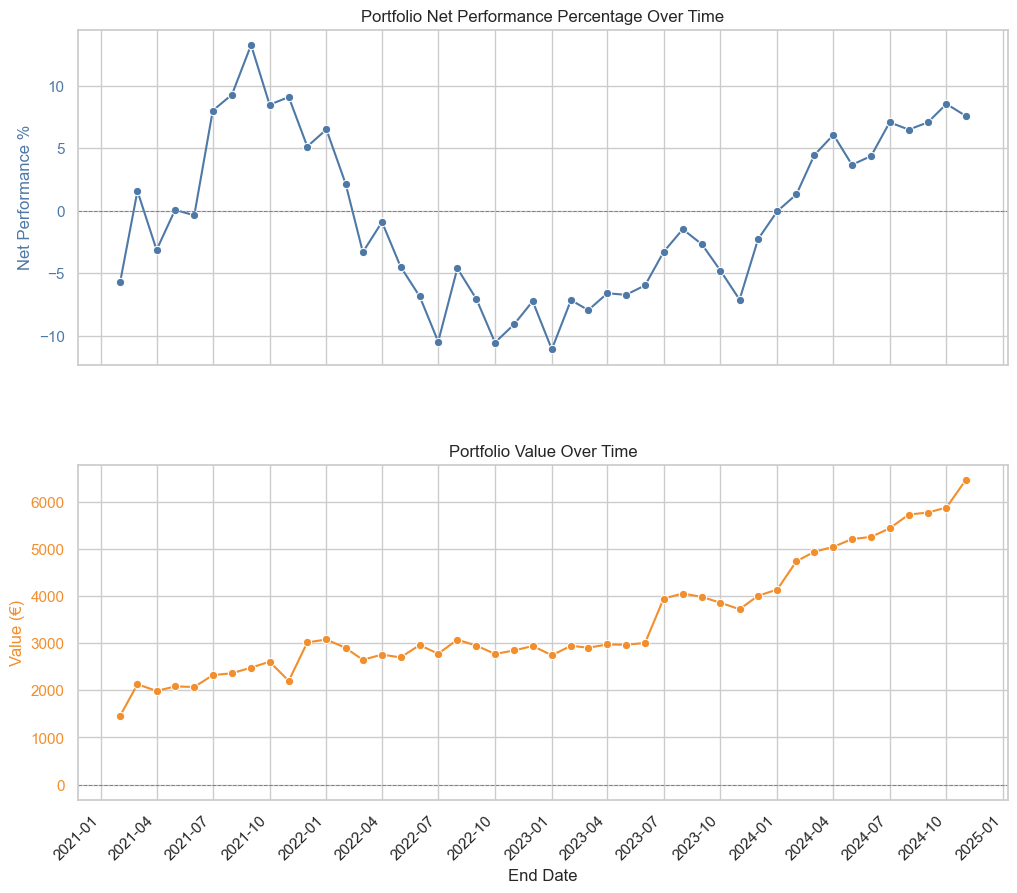

In [47]:
# Convert end_date to datetime if not already done
portfolio_results_df['end_date'] = pd.to_datetime(portfolio_results_df['end_date'])

# Set the theme for a modern look
sns.set_theme(style="whitegrid")

# Define a custom color palette for each graph
performance_color = "#4e79a7"  # Dark blue for net performance percentage
return_color = "#f28e2b"       # Orange for net return in euros

# Create a figure with two subplots, one for each metric
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0.3})

# Plot 'net_performance_percentage' on the first subplot
sns.lineplot(data=portfolio_results_df, x='end_date', y='net_performance_percentage', color=performance_color, marker='o', ax=ax1)
ax1.set_ylabel('Net Performance %', color=performance_color)
ax1.set_title('Portfolio Net Performance Percentage Over Time')
ax1.tick_params(axis='y', labelcolor=performance_color)

# Add zero line for reference
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Plot 'net_return' on the second subplot
sns.lineplot(data=portfolio_results_df, x='end_date', y='current_value', color=return_color, marker='o', ax=ax2)
ax2.set_ylabel('Value (€)', color=return_color)
ax2.set_title('Portfolio Value Over Time')
ax2.tick_params(axis='y', labelcolor=return_color)

# Add zero line for reference
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Set the x-axis major ticks to show quarterly dates
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set the x-axis label on the second plot only
ax2.set_xlabel('End Date')

# Rotate x-axis labels for readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Display the plots
plt.show()


## Daily YTD

Bug when stocks don't have transactions in the defined period AND quantity=0. Is period_transactions empty and not joined correctly?

In [48]:
transactions = df_adj

In [49]:
# Set fixed start date
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
# Initialize today's date as the end of the loop range
today = datetime.today()

# Generate list of end dates for the first day of each month from start date to today
end_dates = pd.date_range(start=start_date, end=today, freq='D')[1:]  # Exclude the start_date itself

# Initialize an empty list to store portfolio data for each month
portfolio_results_list = []

# Define the path to the cache file
cache_file_path = 'data\portfolio_results_ytd.pkl'

# Load existing results from the pickle file if it exists
try:
    portfolio_results_df = pd.read_pickle(cache_file_path)
    print('File found')
except (FileNotFoundError, pd.errors.EmptyDataError):
    # Start with an empty DataFrame if the file doesn't exist
    portfolio_results_df = pd.DataFrame(columns=['product', 'quantity', 'start_date', 'end_date', 
                                                 'avg_cost', 'total_cost', 'current_value', 
                                                 'current_money_weighted_return', 'realized_return', 
                                                 'net_return', 'current_performance_percentage', 
                                                 'net_performance_percentage'])

# Loop over each end date, calculate portfolio results, and add to the list
for end_date in end_dates:
    # Format end date to string for comparison
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    # Check if the result for this end date already exists in the DataFrame
    if not portfolio_results_df[portfolio_results_df['end_date'] == end_date_str].empty:
        continue  # Skip if already present

    print(end_date_str)

    # Ensure that the transactions before the end date are not empty
    transactions_before_end = transactions[(transactions["Date"] <= end_date_str)]
    if transactions_before_end.empty:
        print(f"No transactions found for date: {end_date_str}. Skipping...")
        continue

    stock_list = list(transactions_before_end["Stock"].unique())
    
    result = analyzer.calculate_all_stocks_mwr(
        start_date=start_date.strftime('%Y-%m-%d'), 
        end_date=end_date_str, 
        stocks=stock_list
    )
    
    portfolio_data = result.get('portfolio')
    
    # Check if portfolio_data is valid before proceeding
    if portfolio_data is None or not isinstance(portfolio_data, dict):
        print(f"Portfolio data is missing or invalid for date: {end_date_str}. Result: {result}")
        continue
    
    # Ensure end_date is included in the portfolio_data
    portfolio_data['end_date'] = end_date_str
    
    # Append the new data to the list
    portfolio_results_list.append(portfolio_data)

# Combine the list into a DataFrame if there are new results
if portfolio_results_list:
    new_portfolio_results_df = pd.DataFrame(portfolio_results_list)
    # Append new results to the existing DataFrame
    portfolio_results_ytd_df = pd.concat([portfolio_results_df, new_portfolio_results_df], ignore_index=True)

# Save the updated DataFrame to a pickle file
portfolio_results_ytd_df.to_pickle(cache_file_path)


File found
2024-11-06
2024-11-07


In [50]:
portfolio_results_ytd_df.tail(10)

,product,quantity,start_date,end_date,avg_cost,total_cost,current_value,current_money_weighted_return,realized_return,net_return,current_performance_percentage,net_performance_percentage
654,Full portfolio,320.0,2024-01-01,2024-10-28,5.09,7809.71,6565.16,1082.24,-386.7,695.54,13.86,8.91
655,Full portfolio,320.0,2024-01-01,2024-10-29,5.09,7809.71,6558.16,1075.24,-386.7,688.54,13.77,8.82
656,Full portfolio,320.0,2024-01-01,2024-10-30,5.09,7809.71,6522.36,1039.44,-386.7,652.74,13.31,8.36
657,Full portfolio,320.0,2024-01-01,2024-10-31,5.09,7809.71,6410.79,927.87,-386.7,541.17,11.88,6.93
658,Full portfolio,320.0,2024-01-01,2024-11-01,5.09,7809.71,6461.59,978.67,-386.7,591.97,12.53,7.58
659,Full portfolio,320.0,2024-01-01,2024-11-02,5.09,7809.71,6461.59,978.67,-386.7,591.97,12.53,7.58
660,Full portfolio,320.0,2024-01-01,2024-11-03,5.09,7809.71,6461.59,978.67,-386.7,591.97,12.53,7.58
661,Full portfolio,320.0,2024-01-01,2024-11-04,5.09,7809.71,6427.06,944.14,-386.7,557.44,12.09,7.14
662,Full portfolio,320.0,2024-01-01,2024-11-06,5.09,7809.71,6616.33,1133.41,-386.7,746.71,14.51,9.56
663,Full portfolio,320.0,2024-01-01,2024-11-07,5.09,7809.71,6656.76,1173.84,-386.7,787.14,15.03,10.08


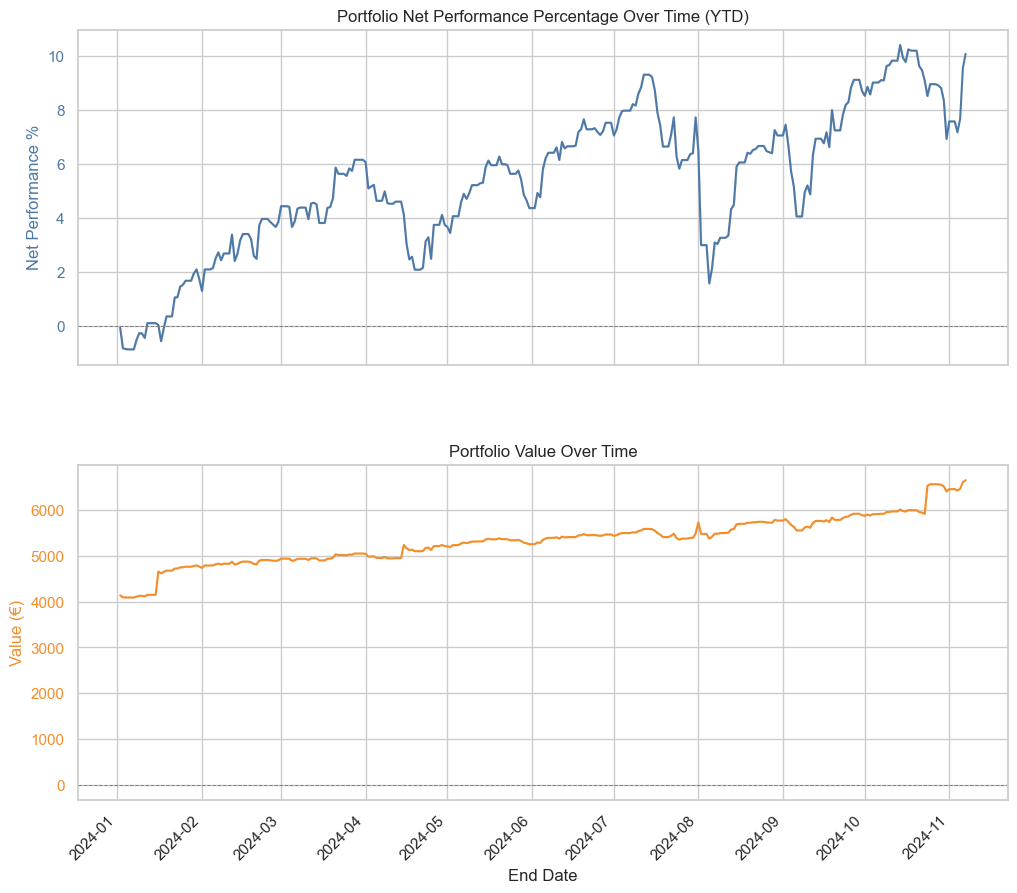

In [51]:
# Convert end_date to datetime if not already done
portfolio_results_ytd_df['end_date'] = pd.to_datetime(portfolio_results_ytd_df['end_date'])

# Set the theme for a modern look
sns.set_theme(style="whitegrid")

# Define a custom color palette for each graph
performance_color = "#4e79a7"  # Dark blue for net performance percentage
return_color = "#f28e2b"       # Orange for net return in euros

# Create a figure with two subplots, one for each metric
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0.3})

# Plot 'net_performance_percentage' on the first subplot
sns.lineplot(data=portfolio_results_ytd_df, x='end_date', y='net_performance_percentage', color=performance_color, marker=None, ax=ax1)
ax1.set_ylabel('Net Performance %', color=performance_color)
ax1.set_title('Portfolio Net Performance Percentage Over Time (YTD)')
ax1.tick_params(axis='y', labelcolor=performance_color)

# Add zero line for reference
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Plot 'net_return' on the second subplot
sns.lineplot(data=portfolio_results_ytd_df, x='end_date', y='current_value', color=return_color, marker=None, ax=ax2)
ax2.set_ylabel('Value (€)', color=return_color)
ax2.set_title('Portfolio Value Over Time')
ax2.tick_params(axis='y', labelcolor=return_color)

# Add zero line for reference
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Set the x-axis major ticks to show quarterly dates
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set the x-axis label on the second plot only
ax2.set_xlabel('End Date')

# Rotate x-axis labels for readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Display the plots
plt.show()

## Last 30 days

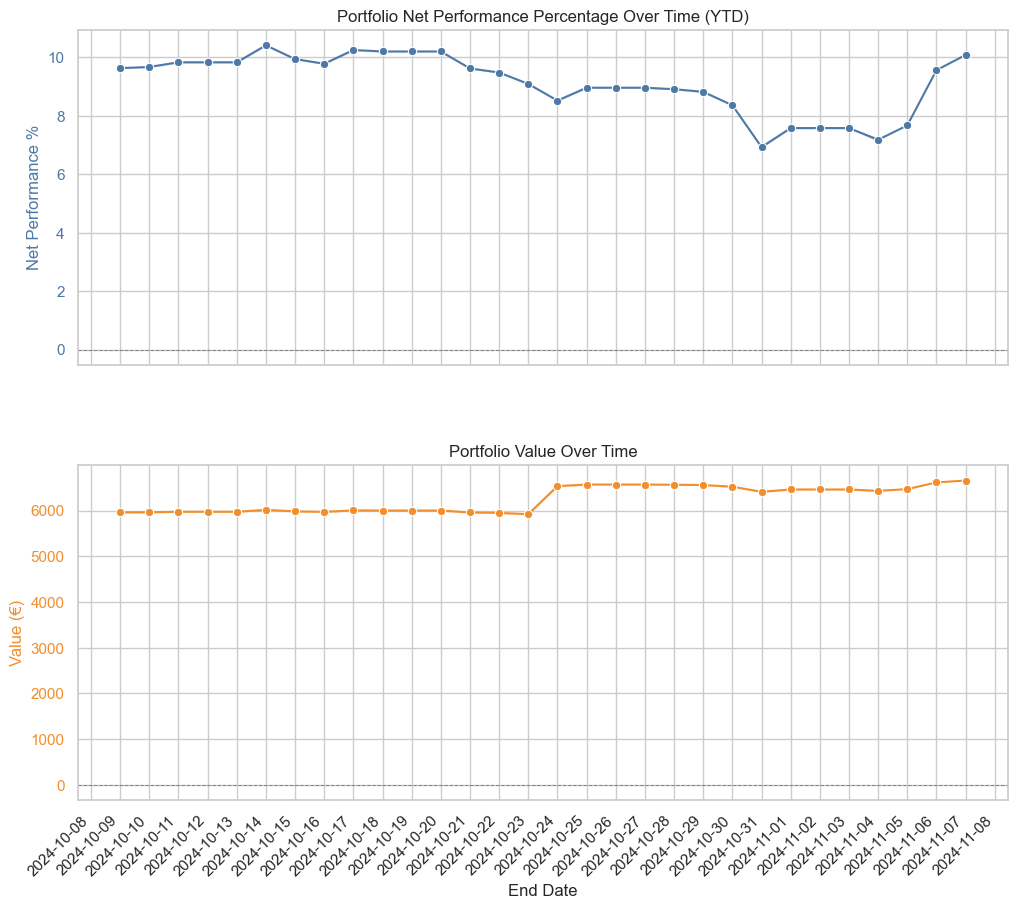

In [52]:
# Convert end_date to datetime if not already done
portfolio_results_ytd_df['end_date'] = pd.to_datetime(portfolio_results_ytd_df['end_date'])

# Define the date 30 days ago from today
thirty_days_ago = datetime.today() - timedelta(days=30)

# Filter for records within the last 30 days
thirty_days_df = portfolio_results_ytd_df[portfolio_results_ytd_df['end_date'] >= thirty_days_ago]

# Set the theme for a modern look
sns.set_theme(style="whitegrid")

# Define a custom color palette for each graph
performance_color = "#4e79a7"  # Dark blue for net performance percentage
return_color = "#f28e2b"       # Orange for net return in euros

# Create a figure with two subplots, one for each metric
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0.3})

# Plot 'net_performance_percentage' on the first subplot
sns.lineplot(data=thirty_days_df, x='end_date', y='net_performance_percentage', color=performance_color, marker='o', ax=ax1)
ax1.set_ylabel('Net Performance %', color=performance_color)
ax1.set_title('Portfolio Net Performance Percentage Over Time (YTD)')
ax1.tick_params(axis='y', labelcolor=performance_color)

# Add zero line for reference
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Plot 'net_return' on the second subplot
sns.lineplot(data=thirty_days_df, x='end_date', y='current_value', color=return_color, marker='o', ax=ax2)
ax2.set_ylabel('Value (€)', color=return_color)
ax2.set_title('Portfolio Value Over Time')
ax2.tick_params(axis='y', labelcolor=return_color)

# Add zero line for reference
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Set the x-axis major ticks to show quarterly dates
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set the x-axis label on the second plot only
ax2.set_xlabel('End Date')

# Rotate x-axis labels for readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Display the plots
plt.show()

In [53]:
# Define the path to the cache file
cache_file_path = 'data\portfolio_results_ytd.pkl'

# Load existing results from the pickle file if it exists
try:
    portfolio_results_df = pd.read_pickle(cache_file_path)
except:
    print("error")

In [54]:
portfolio_results_df

,product,quantity,start_date,end_date,avg_cost,total_cost,current_value,current_money_weighted_return,realized_return,net_return,current_performance_percentage,net_performance_percentage
0,Full portfolio,268.0,2024-10-20,2024-10-21 00:00:00,6.07,7209.72,5958.89,1075.96,-382.7,693.26,14.92,9.62
1,Full portfolio,268.0,2024-10-20,2024-10-22 00:00:00,6.07,7209.72,5949.27,1066.34,-382.7,683.64,14.79,9.48
2,Full portfolio,268.0,2024-10-20,2024-10-23 00:00:00,6.07,7209.72,5921.02,1038.09,-382.7,655.39,14.40,9.09
3,Full portfolio,320.0,2024-10-20,2024-10-24 00:00:00,5.09,7809.71,6535.36,1052.44,-386.7,665.74,13.48,8.52
4,Full portfolio,320.0,2024-10-20,2024-10-25 00:00:00,5.09,7809.71,6569.06,1086.14,-386.7,699.44,13.91,8.96
...,...,...,...,...,...,...,...,...,...,...,...,...
659,Full portfolio,320.0,2024-01-01,2024-11-02,5.09,7809.71,6461.59,978.67,-386.7,591.97,12.53,7.58
660,Full portfolio,320.0,2024-01-01,2024-11-03,5.09,7809.71,6461.59,978.67,-386.7,591.97,12.53,7.58
661,Full portfolio,320.0,2024-01-01,2024-11-04,5.09,7809.71,6427.06,944.14,-386.7,557.44,12.09,7.14
662,Full portfolio,320.0,2024-01-01,2024-11-06,5.09,7809.71,6616.33,1133.41,-386.7,746.71,14.51,9.56
